Load Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Load Data

In [112]:
df = pd.read_excel("/Users/madisonwozniak/Desktop/STAT486/final_project/original_data/food_affordability.xls", sheet_name="Food_afford_cdp_co_region_ca")
df = df.drop(df.index[-1]) # remove last row because it is not part of the data

# Feature Engineering

In [113]:
# make factors 
df['region_code'] = df['region_code'].astype('category')
df['race_eth_code'] = df['race_eth_code'].astype('category')
df['geotypevalue'] = df['geotypevalue'].astype('category')
df['county_fips'] = df['county_fips'].astype('category')

Create features with zip code and lat/lon

In [114]:
all_zipcodes = pd.read_csv('zip_code_database.csv')

# names of all counties in the dataset
counties = ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino',
       'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
       'Ventura', 'Yolo', 'Yuba']

# match my counties with those in the zipcode database
city_zipcodes = all_zipcodes[all_zipcodes['primary_city'].isin(counties)]
features_to_join = city_zipcodes[['latitude', 'longitude', 'primary_city']]
features_to_join['county_name'] = features_to_join['primary_city']
features_to_join = features_to_join.drop('primary_city', axis = 1)

# merge datasets
df = pd.merge(df, features_to_join, on = 'county_name', how = 'outer')

/var/folders/8f/l9_yqvn54_ldh6kclbdcgvfh0000gn/T/ipykernel_59909/73613974.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_to_join['county_name'] = features_to_join['primary_city']


household-level affordability

In [115]:
df['affordability_per_person'] = df['affordability_ratio'] / df['ave_fam_size']

Food Cost Index based on national average

average of high, med, low from:

https://www.ers.usda.gov/data-products/ag-and-food-statistics-charting-the-essentials/food-prices-and-spending/

In [116]:
nat_cost = 10421
df['food_cost_index'] = (df['cost_yr'] / nat_cost) * 100

Binary: is food affordable

In [121]:
df['affordable'] = (df['affordability_ratio'] > 1).astype('category')

In [118]:
df = df.drop(['ind_id', 'ind_definition', 'reportyear', 'version', 'region_name', 'county_fips', 'geotypevalue', 'race_eth_code', 'se_food_afford', 'food_afford_decile'], axis = 1)

```
df[num_pred_names] = df[num_pred_names].apply(pd.to_numeric, errors='coerce')
# consistent types for categorical columns
df[cat_pred_names] = df[cat_pred_names].astype(str)
```

Final dataframe to csv

In [123]:
df.head()

,race_eth_name,geotype,geoname,county_name,region_code,cost_yr,median_income,affordability_ratio,LL95_affordability_ratio,UL95_affordability_ratio,rse_food_afford,CA_RR_Affordability,ave_fam_size,latitude,longitude,affordability_per_person,food_cost_index,affordable
0,AIAN,CO,Alameda,Alameda,1.0,7242.123007,16063.0,0.450857,0.087869,0.813846,41.076862,1.692392,3.21,37.77,-122.27,0.140454,69.495471,False
1,AIAN,CO,Alameda,Alameda,1.0,7242.123007,16063.0,0.450857,0.087869,0.813846,41.076862,1.692392,3.21,37.73,-122.24,0.140454,69.495471,False
2,Asian,CO,Alameda,Alameda,1.0,7242.123007,42048.0,0.172235,0.121394,0.223075,15.060224,0.646520,3.21,37.77,-122.27,0.053656,69.495471,False
3,Asian,CO,Alameda,Alameda,1.0,7242.123007,42048.0,0.172235,0.121394,0.223075,15.060224,0.646520,3.21,37.73,-122.24,0.053656,69.495471,False
4,AfricanAm,CO,Alameda,Alameda,1.0,7242.123007,23858.0,0.303551,0.266850,0.340253,6.168717,1.139445,3.21,37.77,-122.27,0.094564,69.495471,False


In [124]:
df.to_csv('final_data.csv', index = False)

# Supervised Machine Learning Models

In [2]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

In [3]:
df = pd.read_csv('final_data.csv')

### Data Preparation

In [4]:
df['median_income'] = df['median_income'].fillna(df['median_income'].mean()) # make sure response has no NAs

# get my X and Y matrices
X = df.drop(columns = ['median_income'])
y = df['median_income']

In [5]:
# extract only the column names for each type
numeric_features = X.select_dtypes(include = ['number']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=307) # split the data

# make transformers for each data type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler())                  
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('filtering', SelectPercentile(f_regression, percentile=50))     
])

# run both through the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),      
        ('cat', categorical_transformer, categorical_features)  
    ])

In [7]:
# may need to use samples for testing out some models
#X_train_sample = X_train.sample(n=50000, random_state=42)
#y_train_sample = y_train.loc[X_train_sample.index]

# taking the log of income may make most sense
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [130]:
# looking at how my predictors are correlated with the response 
numeric_X_train = X_train.select_dtypes(include=['number'])
corr = numeric_X_train.corrwith(y_train_log)
print(corr.sort_values(ascending=False))

region_code                 0.033225
longitude                   0.006182
food_cost_index            -0.050251
cost_yr                    -0.050251
latitude                   -0.051902
ave_fam_size               -0.081894
rse_food_afford            -0.234692
UL95_affordability_ratio   -0.320606
LL95_affordability_ratio   -0.332208
affordability_ratio        -0.789337
CA_RR_Affordability        -0.789337
affordability_per_person   -0.796739
dtype: float64


### KNeighbors Regressor

In [56]:
# sample KNN Regressor
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=5, weights = 'distance'))  
])

pipe.fit(X_train, y_train_log)
y_pred = pipe.predict(X_test)
test_mse = root_mean_squared_error(y_test_log, y_pred)
print(test_mse) 

0.022768970774101772


Grid Search with KNN

In [13]:
param_grid = {
    'model__n_neighbors': [3, 5],  # Test a range of neighbor counts
    'model__weights': ['uniform'],  # Compare weighting schemes
    'model__p': [2]  # Euclidean (2) distance
}

grid_search = GridSearchCV(
    estimator=pipe,  # The pipeline
    param_grid=param_grid,  # The hyperparameter grid
    scoring='neg_mean_squared_error',  # Scoring metric
    cv=2,  # Number of cross-validation folds
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train_log)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

KeyboardInterrupt: 

Use the best model

In [ ]:
best_model = grid_search.best_estimator_
# Use the best model to predict
y_pred = best_model.predict(X_test)
test_mse = root_mean_squared_error(y_test_log, y_pred)
print(test_mse) #0.020348175708673553

### Linear Regression

Grid Search with Ridge

In [ ]:
ridge_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength for Ridge
}
# GridSearchCV
grid_search = GridSearchCV(ridge_pipe, 
                           param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X_train, y_train_log)
# Results
print(f"Best Parameters: {grid_search.best_params_}") 
#Best Parameters: {'model__alpha': 0.01}
print(f"Best Cross-Validation MSE: {-grid_search.best_score_}") 
#Best Cross-Validation MSE: 0.004297668411110789


Best Parameters: {'model__alpha': 0.01}
Best Cross-Validation MSE: 0.004297668411110789


In [ ]:
best_model = grid_search.best_estimator_
# Use the best model to predict
y_pred = best_model.predict(X_test)
test_mse = root_mean_squared_error(y_test_log, y_pred)
print(test_mse) # 0.06471089441531265

0.06471089441531265


### Decision Trees/Random Forests

In [16]:
import shap
shap.initjs() #helps with the ability to display images in notebook

In [ ]:
# make sure I don't have any nulls
X_train.isnull().sum()
# since I do, I need to impute missing values

race_eth_code                   0
race_eth_name                   0
geotype                         0
geotypevalue                    0
geoname                         0
county_name                     0
county_fips                     0
region_name                     0
region_code                     0
cost_yr                      5114
affordability_ratio         32591
LL95_affordability_ratio    32997
UL95_affordability_ratio    32997
se_food_afford              32997
rse_food_afford             32997
food_afford_decile          45459
CA_RR_Affordability         32591
ave_fam_size                 2462
latitude                      616
longitude                     616
dtype: int64

In [48]:
# make new numeric transformer since I only want to impute now
dt_numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='mean'))
])
dt_preprocessor = ColumnTransformer(
    transformers=[
        ('num', dt_numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
pipe = Pipeline(steps=[
    ('preprocessor', dt_preprocessor),
    ('model', DecisionTreeRegressor(random_state = 42))  
])

Tuning Decision Tree with Grid Search

In [49]:
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train_log)
print(f"Best Parameters: {grid_search.best_params_}")
# Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
print(f"Best MSE: {-grid_search.best_score_}")
# Best MSE: 132159.55162585393

Best Parameters: {'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Best MSE: 0.0006073438722966997


In [50]:
y_test_pred = grid_search.predict(X_test)
test_mse = root_mean_squared_error(y_test_log, y_test_pred)
print(test_mse)
# 287.87320468661073

0.024945518784664947


### Gradient Boosting XGBoost

In [51]:
# need to deal with categorical
X_train_processed = preprocessor.fit_transform(X_train, y_train_log)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# using XGBoost
xgb_model = XGBRegressor(n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         random_state=42,
                        )
xgb_model.fit(X_train_processed, y_train_log)
# maybe add l1/l2 regularization 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Grid Search for Hyperparam Tuning

In [52]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}
gb_grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose = 1
)
gb_grid_search.fit(X_train_processed, y_train_log)
print(f"Best Parameters: {grid_search.best_params_}")
# Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
print(f"Best MSE: {-grid_search.best_score_}")
# Best MSE: 132159.55162585393

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Best MSE: 0.0006073438722966997


Evaluate Grid Search Model

In [53]:
y_test_pred = gb_grid_search.predict(X_test_processed)
mse = root_mean_squared_error(y_test_log, y_test_pred)
print(f'Test rMSE: {mse}')

Test rMSE: 0.006300954981604688


In [24]:
# graph feature importance
feature_importances = gb_grid_search.feature_importances_
plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

## SHAP for XGBoost

 98%|===================| 49156/50000 [01:00<00:01]        

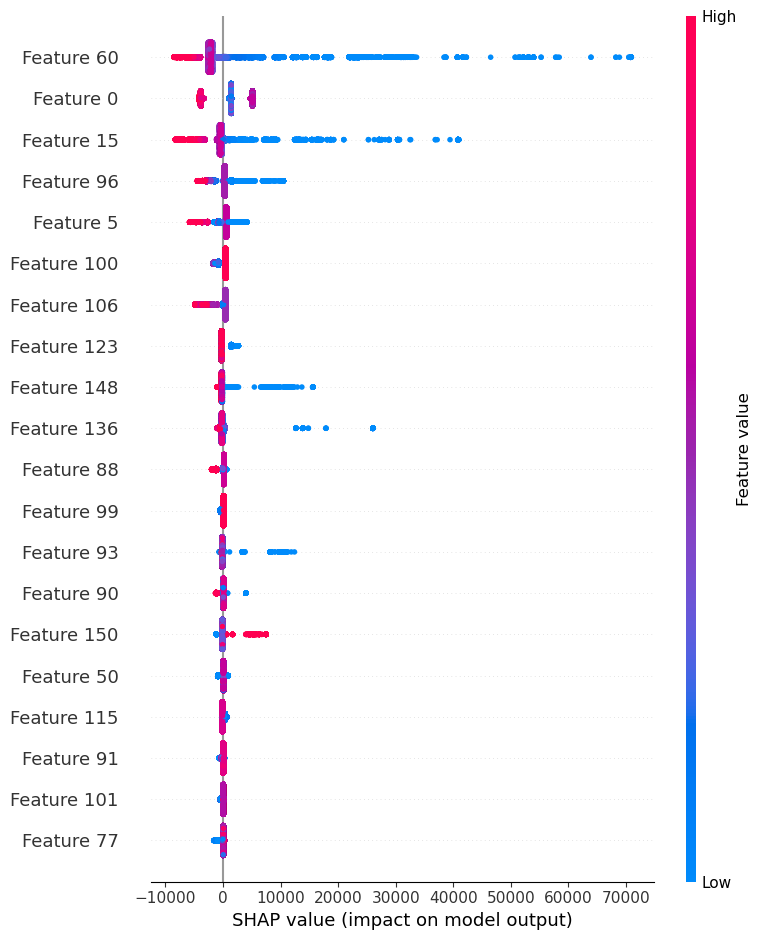

In [64]:
# create explainer for trained model
X_train_dense = X_train_processed.toarray()
explainer = shap.Explainer(xgb_model, X_train_dense)
# get SHAP values
shap_values = explainer(X_train_dense)
#visualize SHAP vals
shap.summary_plot(shap_values, X_train_dense)


In [67]:
# dependence plot - show how a feature impacts predictions
# Replace 'feature_index' with the column index of the feature you want to plot
shap.dependence_plot(feature_index=0, shap_values=shap_values.values, features=X_train_dense)

TypeError: dependence_legacy() got an unexpected keyword argument 'feature_index'

In [68]:
# Replace 'index' with the index of the row you want to explain
shap.force_plot(explainer.expected_value[0], shap_values.values[index, :], X_train_dense[index, :])

IndexError: invalid index to scalar variable.

In [72]:
# what is on class notes
exp = shap.Explanation(
    values=shap_values[:, 1],  # Replace `1` with the correct index if needed
    base_values=explainer.expected_value,  # Scalar value
    data=X_train_processed.toarray(),
    feature_names=vectorizer.get_feature_names_out()
)

NameError: name 'vectorizer' is not defined

# Deep Learning Model with Hyperparam. Optimization

In [25]:
# load all DNN packages
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# scale features 
scaler = StandardScaler(with_mean = False) # since some features are one hot encoded
X_train_DNN = scaler.fit_transform(X_train_processed)  # Preprocessed numeric/categorical data
X_test_DNN = scaler.transform(X_test_processed)

In [ ]:
# transform target

In [27]:
# define neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_DNN.shape[1],)),  # Input layer
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Hidden layer
    Dense(32, activation='relu'),  # Another hidden layer
    Dense(1)  # Output layer for regression
])

In [28]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [44]:
# train the model
# implement early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True)
# convert sparse matrix to dense
X_train_DNN_dense = X_train_DNN.toarray()
history = model.fit(
    X_train_DNN_dense, y_train_log,  # Use log-transformed targets if needed
    validation_split=0.2,  # Use part of the training data for validation
    epochs=10,  # Maximum number of epochs
    batch_size=32,  # Batch size for gradient updates
    callbacks=[early_stopping],  # Add early stopping
    verbose=1  # Print progress
)

Epoch 1/10
5539/5539 [==============================] - 11s 2ms/step - loss: 0.0014 - mae: 0.0191 - val_loss: 0.0016 - val_mae: 0.0176
Epoch 2/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0015 - mae: 0.0196 - val_loss: 0.0014 - val_mae: 0.0176
Epoch 3/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0018 - mae: 0.0201 - val_loss: 0.0026 - val_mae: 0.0339
Epoch 4/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0016 - mae: 0.0197 - val_loss: 0.0012 - val_mae: 0.0165
Epoch 5/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0015 - mae: 0.0197 - val_loss: 0.0014 - val_mae: 0.0240
Epoch 6/10
5539/5539 [==============================] - 8s 2ms/step - loss: 0.0016 - mae: 0.0197 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 7/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0016 - mae: 0.0199 - val_loss: 0.0020 - val_mae: 0.0211
Epoch 8/10
5539/5539 [==============================] - 10s 2

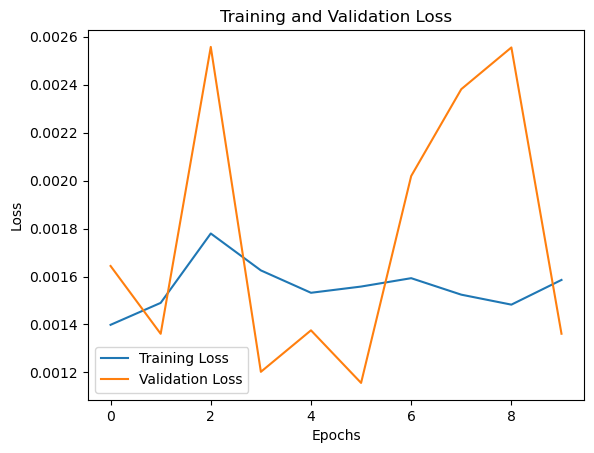

In [45]:
# plot training and validation loss to eval model performance
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [46]:
# evaluate model
# predict on test data
y_test_pred_dnn = model.predict(X_test_DNN)
rmse = root_mean_squared_error(y_test_log, y_test_pred_dnn)
print(f"Test rMSE: {mse}")

2308/2308 [==============================] - 2s 904us/step
Test rMSE: 0.0056736956895219


# Anomaly Detection or Cluster Analysis

Anomaly detection

identify data points significantly different from the rest (represent errors, unusualy events, important patterns)

can help identify income outliers
improve model performance
etc

Cluster Analysis

group similar data points based on characterisetics

reveal natural groupings or patterns

good for segmentation

In [16]:
# import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [80]:
# anomaly detection on income with K Means

cluster = df[['median_income']]
# standardize income 
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster)

# fit K Means
kmeans = KMeans(n_clusters=3, random_state = 42)
df['income_cluster'] = kmeans.fit_predict(cluster_scaled)
# distances to centroid
distances = np.abs(cluster_scaled - kmeans.cluster_centers_[df['income_cluster']])
df['income_dist_centroid'] = distances

# set threshold
threshold = np.percentile(df['income_dist_centroid'], 99) # capture top 1% of anomalies

# label anomalies
df['is_anomaly'] = df['income_dist_centroid'] > threshold

# get anomalies
anomalies = df[df['is_anomaly']]

# visualize anomalies
plt.scatter(df.index, cluster_scaled, c=df['income_cluster'], cmap='viridis', label='Clusters')

plt.scatter(df[df['is_anomaly']].index, df[df['is_anomaly']]['median_income'], color='red', label='Anomalies', edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Standardized Income')
plt.title('K-Means Clustering for Anomaly Detection')
plt.legend()
plt.show()

In [109]:
df.columns

Index(['ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
       'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_name',
       'county_fips', 'region_name', 'region_code', 'cost_yr', 'median_income',
       'affordability_ratio', 'LL95_affordability_ratio',
       'UL95_affordability_ratio', 'se_food_afford', 'rse_food_afford',
       'food_afford_decile', 'CA_RR_Affordability', 'ave_fam_size', 'version',
       'latitude', 'longitude', 'affordability_per_person', 'income_cluster',
       'income_dist_centroid', 'is_anomaly'],
      dtype='object')

/var/folders/8f/l9_yqvn54_ldh6kclbdcgvfh0000gn/T/ipykernel_49542/1906728021.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_here['cluster'] = kmeans.fit_predict(X)


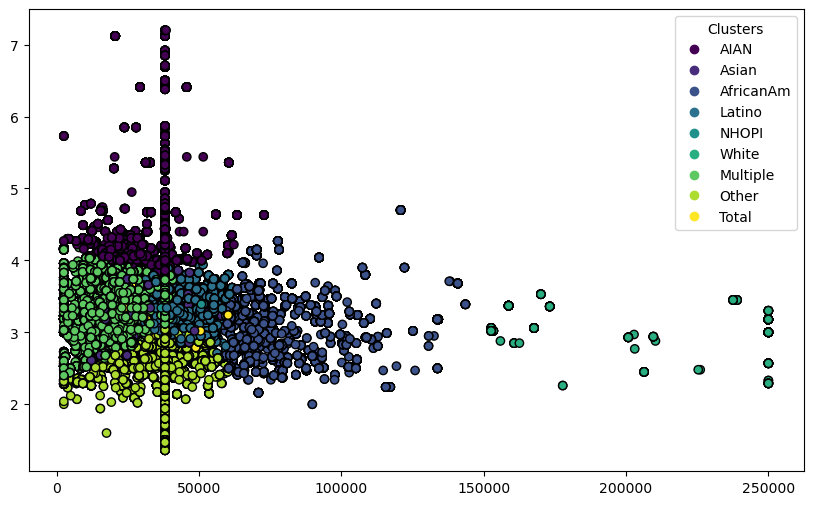

In [113]:
# anomaly detection on income, family size, race with K Means
features = df[['median_income','ave_fam_size', 'race_eth_name']]

df_here = df.dropna(subset=['median_income','ave_fam_size', 'race_eth_name'])  # Drop rows with missing values

# preprocess data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['median_income', 'ave_fam_size']),  # Scale numeric features
        ('cat', OneHotEncoder(), ['race_eth_name'])  # Encode categorical features
    ]
)

X = preprocessor.fit_transform(df_here)

# fit K Means
n_clusters = df['race_eth_name'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
df_here['cluster'] = kmeans.fit_predict(X)


plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_here['median_income'],
    df_here['ave_fam_size'],
    c=df_here['cluster'],  # Color by cluster
    cmap='viridis',
    edgecolor='k'
)

handles, _ = scatter.legend_elements()
legend_labels = df['race_eth_name'].unique()
plt.legend(handles, legend_labels, title="Clusters")

Some racial groups tend to cluster into lower-income categories

large family size doesn't seem to have a relationship with income level

In [ ]:
# Analyze centroids
print(kmeans.cluster_centers_)

silhouette = silhouette_score(X, df_here['cluster'])
print(f'Silhouette Score: {silhouette}')

# Dimension Reduction 

simplifying datasets with many features while keeping the most important info

In [17]:
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE
import umap

PCA

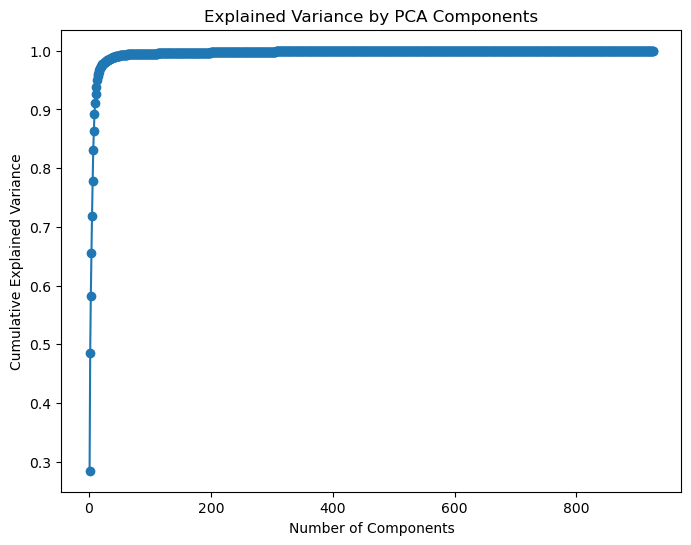

Number of components to retain 95% variance: 14


In [18]:
# using explained variance ratio to choose n_components

pca = PCA()
pca.fit(X_train_processed)

# plot cumulative variance explained by the components to visualize how much info each component adds
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

# set threshold to see how much variance to retain and find number of components needed to achieve that
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = (cumulative_variance >= 0.95).argmax() + 1
print(f"Number of components to retain 95% variance: {n_components}")


In [35]:
pca_start = time.time()
pca = PCA(n_components=2) # on train to avoid data leakage
## pca analyzes structure of training data and finds principle components (linear combinations of original features that maximize variance)
X_train_pc = pca.fit_transform(X_train_processed.toarray()) # project training data into lower-dimension
X_test_pc = pca.transform(X_test_processed)  # now this can be used for an improved model
pca_end = time.time()
print("PCA time (min): ", (pca_end-pca_start)/60)

PCA time (min):  0.04387959639231364


In [20]:
pca.explained_variance_ratio_.sum() # makes sense because that was my threshold

0.9569773571691313

In [44]:
sns.scatterplot(x=X_train_pc[:, 0], y=X_train_pc[:, 1], hue = y_aligned, palette='tab10')
plt.legend(loc=(1.04, 0))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Clusters')
plt.show()

ValueError: array length 50000 does not match index length 221528

TSNE

In [34]:
# works by preserving the pairwise similarities between points from the high dim space to low dim space
tsne_start = time.time()
# n_components = dimensionality of output space
tn = TSNE(n_components=2, perplexity=30, init = 'pca').fit_transform(X_train_pc)  
# perplexity = how many neighbors to include
# init tells where to initialize 
tsne_end = time.time()
print("TSNE time (min): ", (tsne_end-tsne_start)/60)

KeyboardInterrupt: 

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

UMAP

faster than tSNE

balances preserving global relationships and local neighbors better than tSNE

In [48]:
umap_start = time.time()
um = umap.UMAP(n_components=2, n_neighbors=15).fit_transform(X_train_pc)  
# n_neighbors might need to be adjusted to improve connectivity
umap_end = time.time()
print("UMAP time (min): ", (umap_end-umap_start)/60)

/Users/madisonwozniak/miniconda3/envs/stat486/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP time (min):  1.742519768079122


ValueError: 'c' argument has 221528 elements, which is inconsistent with 'x' and 'y' with size 50000.

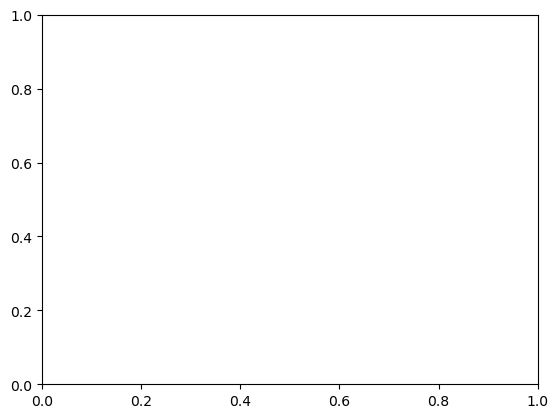

In [50]:
plt.scatter(um[:, 0], um[:, 1], c=y_train, cmap='viridis', s=10)
plt.colorbar()
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization')
plt.show()